In [1]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import tqdm
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse


In [ ]:
def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df

In [2]:
# Specify the directory where CSV files are located
results_directory = "../Results/Summary/"

# Use os.path.join for path construction
csv_files = glob.glob(os.path.join(results_directory, '*_summary_MI_hvg.csv'))

# Use tqdm to add a progress bar during concatenation
dfs = []
for csv_file in tqdm(csv_files, desc='Reading CSV files', unit='file'):
    df = pd.read_csv(csv_file, index_col=[0])
    dfs.append(df)

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Display the concatenated DataFrame
df.head()


Reading CSV files:  17%|█▋        | 1/6 [00:00<00:01,  4.83file/s]

Reading CSV files: 100%|██████████| 6/6 [00:01<00:00,  5.06file/s]


,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,0,WSB1,0.080830,3.681056e-05,0.091596,3.488596e-06,0.060802,0.684259,0.049854,CID4290,BC_visium,deepspace
1,1,MTUS1,0.049292,7.867436e-03,0.055584,3.227185e-03,0.042992,0.537210,0.038030,CID4290,BC_visium,deepspace
2,2,PATJ,-0.019836,8.343135e-01,0.002619,4.489841e-01,-0.004087,0.440835,-0.004568,CID4290,BC_visium,deepspace
3,3,ORAI2,0.000563,4.890120e-01,0.021852,1.422872e-01,0.009482,0.383502,0.001158,CID4290,BC_visium,deepspace
4,4,TGFB1I1,0.155290,1.004125e-14,0.151771,3.869639e-14,0.091739,0.553297,0.107432,CID4290,BC_visium,deepspace


In [3]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)


In [5]:
# df.to_csv("../Results/Summary/summary_MI_hvg.csv")

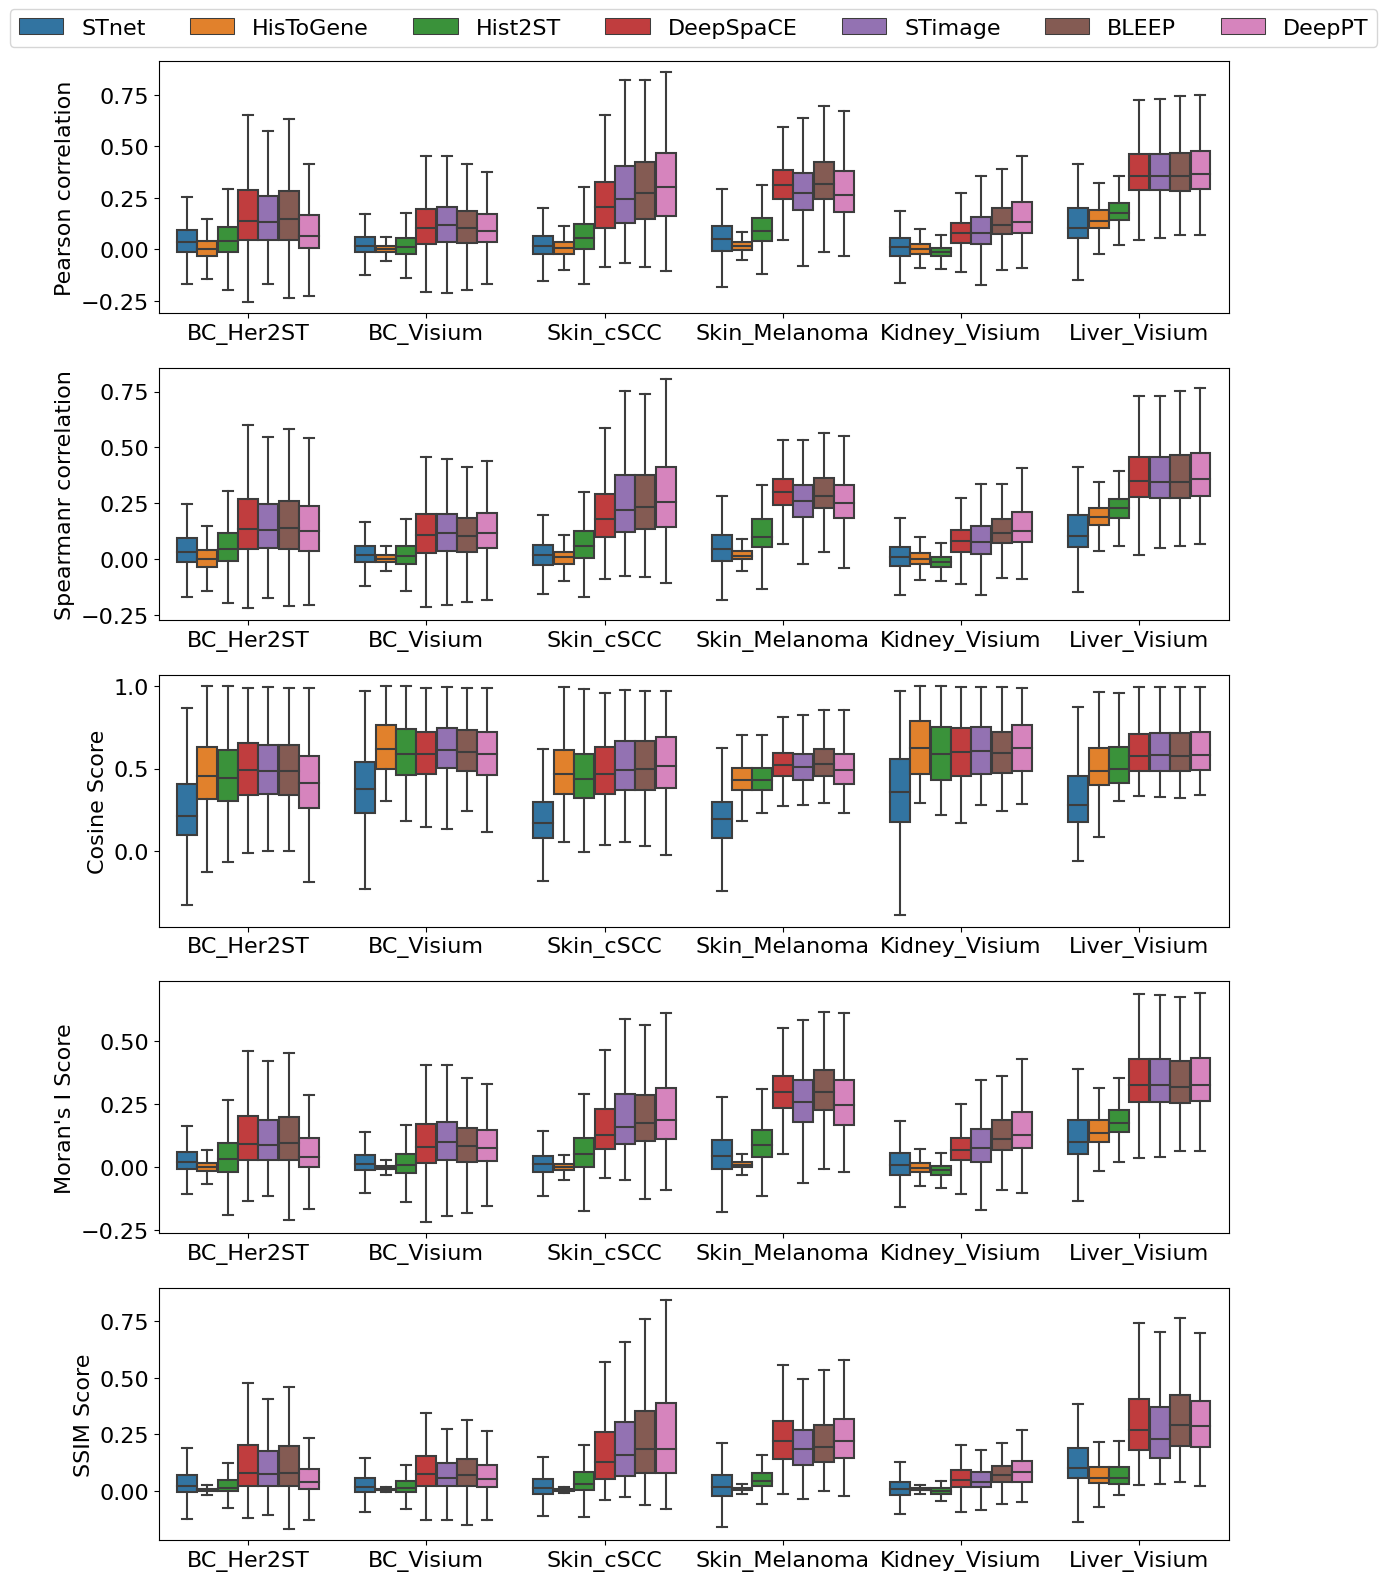

5

In [26]:
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(5, 1, figsize=(14, 16))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df, ax=axs[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig("hvg_full_res.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


In [36]:
df.groupby(["Dataset", "Method"]).agg({
    "Pearson correlation": ["median", "mean", "min", "max", "std"]
}).sort_values(by=("Pearson correlation", "median"), ascending=False).sort_index(level=0)


Pearson correlation                                \
                                     median      mean       min       max   
Dataset       Method                                                        
BC_Her2ST     STnet                0.034386  0.050084 -0.253325  0.640093   
              HisToGene            0.002220  0.002671 -0.256578  0.262439   
              Hist2ST              0.041827  0.053710 -0.385559  0.657335   
              DeepSpaCE            0.137958  0.183156 -0.253898  0.848292   
              STimage              0.134520  0.170606 -0.167899  0.838198   
              BLEEP                0.145973  0.180210 -0.236324  0.830730   
              DeepPT               0.066505  0.102698 -0.259284  0.805698   
BC_Visium     STnet                0.018183  0.026660 -0.342552  0.383637   
              HisToGene            0.002065  0.002482 -0.125478  0.143011   
              Hist2ST              0.011332  0.020841 -0.447234  0.454588   
              DeepSpaCE            0.103485  0.126023 -0.236270  0.604700   
              STimage              0.117408  0.131814 -0.264953  0.641563   
              BLEEP                0.104503  0.118106 -0.265591  0.588667   
              DeepPT               0.089709  0.112427 -0.288521  0.606837   
Skin_cSCC     STnet                0.017866  0.023372 -0.457053  0.396497   
              HisToGene            0.007049  0.006339 -0.153762  0.161048   
              Hist2ST              0.056004  0.066809 -0.474936  0.405780   
              DeepSpaCE            0.204829  0.227009 -0.087887  0.748711   
              STimage              0.243232  0.276856 -0.064789  0.824216   
              BLEEP                0.274532  0.297751 -0.087082  0.824672   
              DeepPT               0.301277  0.323224 -0.105180  0.859490   
Skin_Melanoma STnet                0.049597  0.055342 -0.331674  0.399133   
              HisToGene            0.014557  0.019688 -0.054305  0.188426   
              Hist2ST              0.088965  0.096506 -0.186964  0.331772   
              DeepSpaCE            0.314054  0.318600 -0.041426  0.694151   
              STimage              0.276123  0.280101 -0.081811  0.647055   
              BLEEP                0.319726  0.332075 -0.013258  0.753444   
              DeepPT               0.266201  0.283865 -0.034428  0.673052   
Kidney_Visium STnet                0.009408  0.014237 -0.277280  0.484225   
              HisToGene            0.002263  0.004990 -0.182197  0.210498   
              Hist2ST             -0.012418 -0.015985 -0.202667  0.149670   
              DeepSpaCE            0.079176  0.089310 -0.289577  0.596753   
              STimage              0.080634  0.099929 -0.273640  0.574171   
              BLEEP                0.120227  0.143438 -0.175730  0.649804   
              DeepPT               0.132256  0.166268 -0.088872  0.611050   
Liver_Visium  STnet                0.105995  0.153665 -0.150872  0.717317   
              HisToGene            0.140134  0.156550 -0.031544  0.586804   
              Hist2ST              0.177692  0.195579 -0.037220  0.771358   
              DeepSpaCE            0.354471  0.390331  0.046174  0.840119   
              STimage              0.356660  0.390568  0.053359  0.838457   
              BLEEP                0.356430  0.392630  0.071025  0.847870   
              DeepPT               0.365424  0.399844  0.071636  0.861589   

                                   
                              std  
Dataset       Method               
BC_Her2ST     STnet      0.095101  
              HisToGene  0.056757  
              Hist2ST    0.104159  
              DeepSpaCE  0.181971  
              STimage    0.162978  
              BLEEP      0.170239  
              DeepPT     0.138531  
BC_Visium     STnet      0.069347  
              HisToGene  0.024078  
              Hist2ST    0.079608  
              DeepSpaCE  0.129135  
              STimage    0.126845  
              BLEE

In [35]:
df.groupby(["Dataset", "Method"]).agg({
    "Moran'I_Score": ["median", "mean", "min", "max", "std"]
}).sort_values(by=("Moran'I_Score", "median"), ascending=False).sort_index(level=0)


Moran'I_Score                                        
                               median      mean       min       max       std
Dataset       Method                                                         
BC_Her2ST     STnet          0.021396  0.038329 -0.186194  0.592104  0.072911
              HisToGene      0.001319  0.001476 -0.139094  0.153035  0.027869
              Hist2ST        0.033744  0.045270 -0.368676  0.610058  0.098623
              DeepSpaCE      0.094123  0.140144 -0.134287  0.779925  0.151830
              STimage        0.089850  0.129543 -0.112531  0.742854  0.136515
              BLEEP          0.097021  0.132575 -0.243712  0.761254  0.138732
              DeepPT         0.042252  0.077545 -0.226881  0.723855  0.114668
BC_Visium     STnet          0.015228  0.023038 -0.312641  0.337879  0.059536
              HisToGene     -0.000313 -0.000468 -0.117795  0.066383  0.013001
              Hist2ST        0.010805  0.019994 -0.447612  0.449101  0.077901
              DeepSpaCE      0.080498  0.107724 -0.223760  0.568255  0.120527
              STimage        0.100582  0.114764 -0.269264  0.589418  0.114500
              BLEEP          0.083381  0.098461 -0.246011  0.552882  0.100299
              DeepPT         0.075679  0.097917 -0.251129  0.555181  0.102606
Skin_cSCC     STnet          0.012098  0.016372 -0.392625  0.316958  0.065103
              HisToGene      0.001172  0.001188 -0.085293  0.071377  0.020248
              Hist2ST        0.054029  0.064886 -0.468475  0.401719  0.090155
              DeepSpaCE      0.127912  0.162938 -0.041233  0.589667  0.121726
              STimage        0.162283  0.199513 -0.049648  0.649283  0.140607
              BLEEP          0.177374  0.206957 -0.123803  0.655707  0.136034
              DeepPT         0.188259  0.220084 -0.090682  0.677045  0.142044
Skin_Melanoma STnet          0.046730  0.051871 -0.310774  0.387878  0.088903
              HisToGene      0.010561  0.016043 -0.037734  0.134385  0.023459
              Hist2ST        0.089212  0.095904 -0.187834  0.322899  0.072912
              DeepSpaCE      0.300730  0.299065 -0.046090  0.679954  0.099892
              STimage        0.261598  0.260692 -0.062335  0.628722  0.111127
              BLEEP          0.299799  0.307165 -0.023858  0.729518  0.107731
              DeepPT         0.247913  0.259542 -0.018514  0.647710  0.119558
Kidney_Visium STnet          0.009380  0.014130 -0.269202  0.474463  0.076926
              HisToGene     -0.000703  0.000573 -0.171845  0.200910  0.037353
              Hist2ST       -0.009960 -0.015570 -0.191914  0.119910  0.032603
              DeepSpaCE      0.070971  0.078668 -0.300083  0.584296  0.106086
              STimage        0.077067  0.097185 -0.258269  0.567591  0.117194
              BLEEP          0.114304  0.135963 -0.165681  0.639976  0.095687
              DeepPT         0.128100  0.160070 -0.101901  0.590507  0.121532
Liver_Visium  STnet          0.099424  0.146390 -0.135118  0.696990  0.139095
              HisToGene      0.137868  0.153868 -0.032928  0.597667  0.073059
              Hist2ST        0.175259  0.193711 -0.031619  0.765820  0.085277
              DeepSpaCE      0.325985  0.361859  0.037673  0.813382  0.138721
              STimage        0.327260  0.360371  0.039329  0.803550  0.134044
              BLEEP          0.319076  0.355322  0.066267  0.803115  0.138056
              DeepPT         0.328629  0.362998  0.066892  0.823640  0.137782

# Predictable genes for each dataset and method

In [4]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res/"

# List of dataset names
datasets = ["Skin_Melanoma", "BC_Her2ST", "Liver_visium", "Skin_cSCC", "Kidney_visium", "BC_visium"]

# Iterate over datasets
for dataset_name in datasets:
    # Read the functional gene results for the current dataset
    df_func = pd.read_csv(os.path.join(functional_results_directory, f"{dataset_name}_summary_MI_hvg.csv"))

    # List of methods
    methods = ["deeppt", "hist2st", "histogene", "stimage", "bleep", "stnet", "deepspace"]

    # Get predictable genes for each method
    predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

    # Find the intersection of predictable genes across all methods
    predictable_genes = list(set.intersection(*predictable_genes_sets))
    print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

    # Subset the original DataFrame for predictable genes
    df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

    # Save the results for predictable genes
    predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_hvg.csv")
    df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*_hvg.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


There are 70 genes that are predictable by all methods for Skin_Melanoma.
There are 149 genes that are predictable by all methods for BC_Her2ST.
There are 408 genes that are predictable by all methods for Liver_visium.
There are 171 genes that are predictable by all methods for Skin_cSCC.
There are 42 genes that are predictable by all methods for Kidney_visium.
There are 64 genes that are predictable by all methods for BC_visium.


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,43,43,RPS25,0.004755,3.938432e-01,0.031886,3.543487e-02,0.016711,0.903166,0.010776,A,Kidney_visium,hist2st
1,47,47,RPL38,0.051207,1.853994e-03,0.053836,1.139590e-03,0.063944,0.917139,0.024853,A,Kidney_visium,hist2st
2,110,110,RPL13A,0.016822,1.703509e-01,0.033933,2.728102e-02,0.038710,0.959431,0.016396,A,Kidney_visium,hist2st
3,123,123,RPS18,0.010879,2.688913e-01,0.025974,7.060478e-02,0.028541,0.940042,0.050731,A,Kidney_visium,hist2st
4,187,187,RPS21,0.046021,4.556568e-03,0.069656,3.911975e-05,0.058368,0.919686,0.046058,A,Kidney_visium,hist2st
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71577,14359,166,DDX18,0.112159,6.041126e-05,0.115901,3.540068e-05,0.068018,0.350960,0.070559,P9_ST_rep3,Skin_cSCC,stimage
71578,14360,167,FLG,0.153464,6.639374e-08,0.136454,1.403932e-06,0.051105,0.290372,0.096077,P9_ST_rep3,Skin_cSCC,stimage
71579,14361,168,NEMF,0.199373,2.960862e-12,0.166136,5.440076e-09,0.118901,0.363573,0.119571,P9_ST_rep3,Skin_cSCC,stimage
71580,14362,169,DYNC1I2,0.119720,2.017727e-05,0.116506,3.241947e-05,0.093722,0.458549,0.086050,P9_ST_rep3,Skin_cSCC,stimage


In [8]:
for dataset_name in ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']:
    res = list(df_combined_predictable[df_combined_predictable["Dataset"]==dataset_name].Gene.unique())
   
    # Specify the file path
    file_path = f'../Dataset/Gene_list/predictable_genes_{dataset_name}_hvg.txt'
    
    # Open the file in write mode
    with open(file_path, 'w') as file:
        # Write each item in the list to a new line in the file
        for item in res:
            file.write(f"{item}\n")
    
    print(f"List has been written to {file_path}")


List has been written to ../Dataset/Gene_list/predictable_genes_BC_Her2ST_hvg.txt
List has been written to ../Dataset/Gene_list/predictable_genes_BC_Visium_hvg.txt
List has been written to ../Dataset/Gene_list/predictable_genes_Skin_cSCC_hvg.txt
List has been written to ../Dataset/Gene_list/predictable_genes_Skin_Melanoma_hvg.txt
List has been written to ../Dataset/Gene_list/predictable_genes_Kidney_Visium_hvg.txt
List has been written to ../Dataset/Gene_list/predictable_genes_Liver_Visium_hvg.txt


In [22]:
import pandas as pd

# Assuming df_combined_predictable is your DataFrame

# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df_combined_predictable.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)
df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)


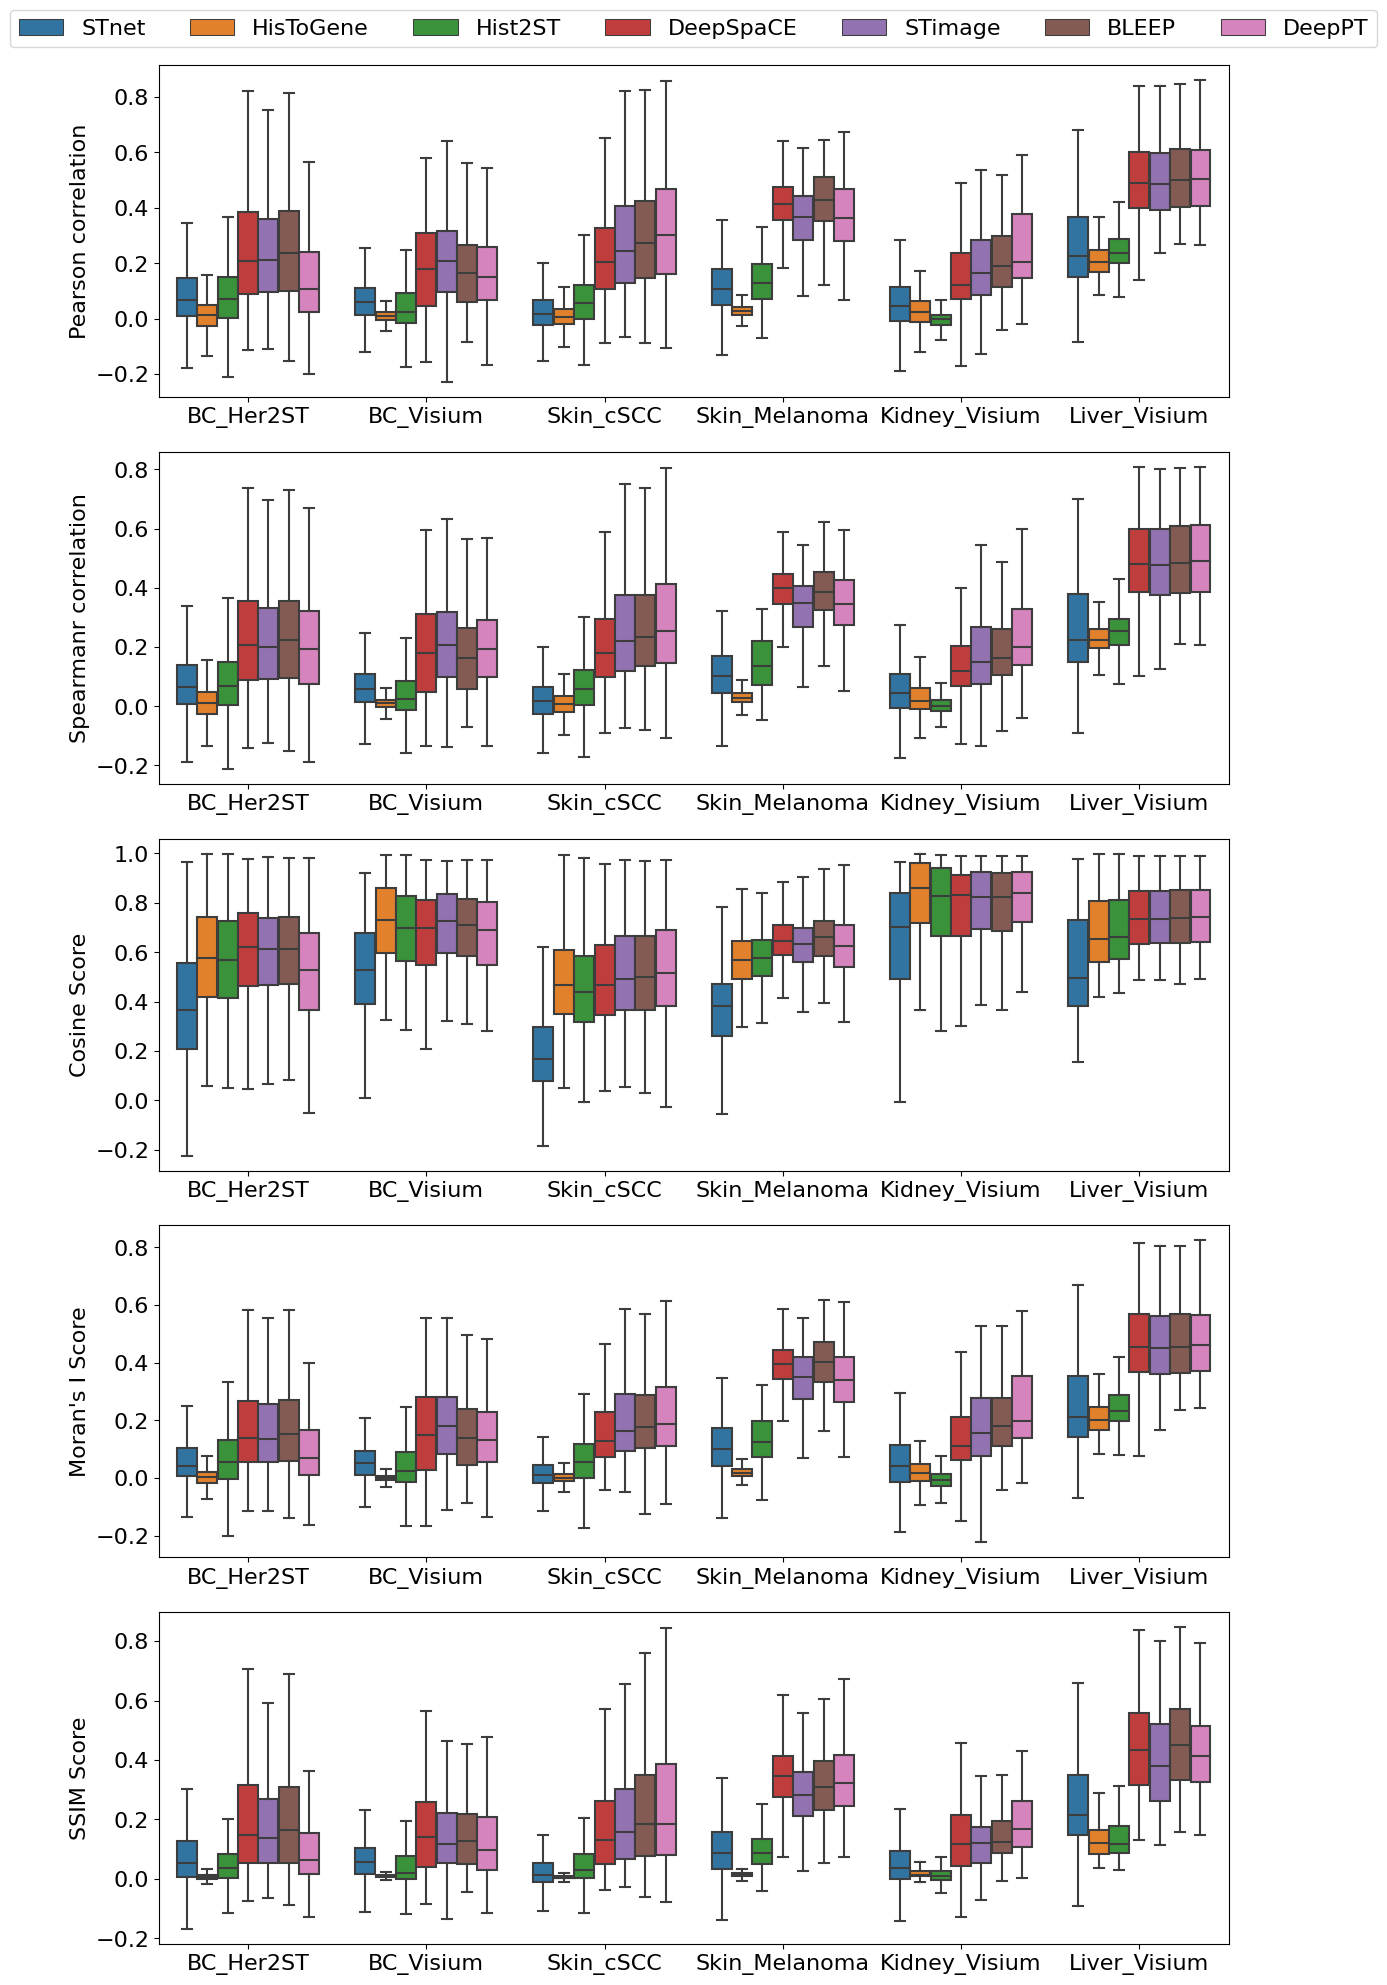

715

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(5, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig("ID_generalize_hvg_predictable.pdf")

# Show the plotsd
plt.show()

# Collect garbage to free up memory
gc.collect()
